# Pareto Frontier for Adders and Multipliers/Dividers

This notebook contains the Pareto frontier resource estimations for adders (in place, out of place, and constant) for n=2^11. Also, the Pareto frontier resource estimations for multipliers and dividers is included for n=2^9.

First, the estimation functions and arithemtic operations must be defined.

In [159]:
import qsharp
import qsharp_widgets
import json
from diskcache import Cache
import re_utils
from math import ceil
from matplotlib import pyplot as plt
from matplotlib import colors

cache = Cache("~/quant-arith-cache/re-pareto")
qsharp.init(project_root="../lib/")

@cache.memoize()
def estimate_resources_in_place_adder_pareto(op, n):
    est = qsharp.estimate(f"EstimateUtils.RunBinaryOpInPlace({n},{op})", params={"estimateType": "frontier"})
    return est

# These all are in-place adders modulo 2^n.
ops_and_max_n_in_place = [
  ("Std.Arithmetic.RippleCarryCGIncByLE", "Gidney*", 2**20),
#   ("Std.Arithmetic.RippleCarryTTKIncByLE", "TTK†", 2**20),
  # ("QuantumArithmetic.CDKM2004.Add", "CDKM-In", 2**20),
#   ("QuantumArithmetic.DKRS2004.Add", "DKRS§", 2**20),
  # ("QuantumArithmetic.JHHA2016.Add_Mod2N", "JHHA-In", 2**20),
#   ("QuantumArithmetic.TR2013.Add", "TR-In", 2**20),
#   ("Std.Arithmetic.FourierTDIncByLE", "QFT-In", 9742),
]

@cache.memoize()
def estimate_resources_out_of_place_adder_pareto(op, n):
    if op == "QuantumArithmetic.WBC2023.AddWithOp":
        radix = ceil(n / 2)
        est = qsharp.estimate(f"EstimateUtils.RunRadix({n},{radix},{op},Std.Arithmetic.RippleCarryCGAddLE)", params={"estimateType": "frontier"})
    else:
        est = qsharp.estimate(f"EstimateUtils.Run3WayOp({n},{n},{n},{op})", params={"estimateType": "frontier"})
    return est
  
# These all are out-of-place adders modulo 2^n.
ops_and_max_n_out_place = [
  ("Std.Arithmetic.RippleCarryCGAddLE", "Gidney-Out", 2**20),
#   ("Std.Arithmetic.LookAheadDKRSAddLE", "DKRS-Out", 2**20),
#   ("QuantumArithmetic.CT2002.Add", "CT-Out", 2**20),
  ("QuantumArithmetic.GKDKH2021.Add_Mod2N", "Gayathri-Out", 2**20),
  ("QuantumArithmetic.WLLQW2016.Add_Mod2N", "Wang-Out", 2**20),      
#   ("QuantumArithmetic.WBC2023.AddWithOp", "HiRadix-Out", 2**20),
#   ("QuantumArithmetic.SC2023.Add_Mod2N", "Ling Structure-Out", 110218),
]

@cache.memoize()
def estimate_resources_constant_adder_pareto(op, n):
    est = qsharp.estimate(f"EstimateUtils.RunConstantAdder({n},{op})", params={"estimateType": "frontier"})
    return est    

ops_and_max_n_constant = [
  # ("Std.Arithmetic.IncByLUsingIncByLE(Std.Arithmetic.RippleCarryTTKIncByLE,_,_)", "TTK-Const", 2**20),
  # ("Std.Arithmetic.IncByLUsingIncByLE(Std.Arithmetic.RippleCarryCGIncByLE,_,_)", "Gidney-Const", 2**20),
  # ("Std.Arithmetic.IncByLUsingIncByLE(QuantumArithmetic.JHHA2016.Add_Mod2N,_,_)", "JHHA-Const", 2**20),
  # ("Std.Arithmetic.IncByLUsingIncByLE(QuantumArithmetic.CDKM2004.Add,_,_)", "CDKM-Const", 2**20),
  # ("Std.Arithmetic.IncByLUsingIncByLE(QuantumArithmetic.DKRS2004.Add,_,_)", "DKRS-Const", 2**20),
#   ("QuantumArithmetic.ConstAdder.AddConstant", "ConstAdder", 2**20),      
#   ("QuantumArithmetic.PG2012.AddConstantQFT", "QFT-Const", 27554),
]

@cache.memoize()
def estimate_resources_multiply_pareto(op, n):
    est = qsharp.estimate(f"EstimateUtils.RunMultiply({n},{op})", params={"estimateType": "frontier"})
    return est

ops_and_max_n_multiply = [
  ("QuantumArithmetic.JHHA2016.Multiply", "JHHA", 2**15),
  ("QuantumArithmetic.MCT2017.Multiply", "MCT", 2**15),
  ("QuantumArithmetic.CG2019.MultiplyKaratsuba32", "Karatsuba", 2**15),
  ("QuantumArithmetic.CG2019.MultiplyKaratsuba", "Karatsuba-8", 27554),
  ("QuantumArithmetic.CG2019.MultiplySchoolbook", "Schoolbook", 11585),
#   ("QuantumArithmetic.OFOSG2023.MultiplyWallaceTree", "Wallace Tree", 1024),
]

@cache.memoize()
def estimate_resources_divide_pareto(op, n):
    if ";" in op:
        divider_type, adder = op.split(";")
        if divider_type == "Restoring":
            est = qsharp.estimate(f"QuantumArithmetic.TMVH2019Test.RunForRE_Restoring({n},{adder})", params={"estimateType": "frontier"} )
        elif divider_type == "NonRestoring":
            est = qsharp.estimate(f"QuantumArithmetic.TMVH2019Test.RunForRE_NonRestoring({n},{adder})", params={"estimateType": "frontier"})
        else:
            raise ValueError("Unknown divider_type")
    elif op == "AKBF2011.Divide_Restoring":
        est = qsharp.estimate(f"QuantumArithmetic.AKBF2011Test.RunForRE_Divide_Restoring({n})", params={"estimateType" : "frontier"})
    else:
        raise ValueError("Unknown op")
    return est

ops_and_max_n_divide = [
  ("NonRestoring;Std.Arithmetic.RippleCarryCGIncByLE", "NR+Gidney", 2**14),
  ("NonRestoring;Std.Arithmetic.RippleCarryTTKIncByLE", "NR+TTK‡", 2**14),
  # ("NonRestoring;QuantumArithmetic.CDKM2004.Add", "NR+CDKM", 2**12),
  # ("NonRestoring;QuantumArithmetic.JHHA2016.Add_Mod2N", "NR+JHHA", 2**12),
  ("Restoring;Std.Arithmetic.RippleCarryCGIncByLE", "R+Gidney", 2**12),
  ("Restoring;Std.Arithmetic.RippleCarryTTKIncByLE", "R+TTK", 2**14),
  ("Restoring;QuantumArithmetic.CDKM2004.Add", "R+CDKM", 2**12),
  ("Restoring;QuantumArithmetic.JHHA2016.Add_Mod2N", "R+JHHA", 2**12),
  ("AKBF2011.Divide_Restoring", "AKBF", 2**12),
]

## Adders

The code section below runs the resource estimation with the Pareto frontier option for the in place, out of place, and constant adders. The results are combined for later use.

In [160]:
n = 2**11
names = []

results = [] 
i = 0 

# in place adders first
for op, name, _ in ops_and_max_n_in_place:
    results.append(estimate_resources_in_place_adder_pareto(op, n))
    names.append(name)
# out of place adders second
for op, name, _ in ops_and_max_n_out_place:
    results.append(estimate_resources_out_of_place_adder_pareto(op, n))
    names.append(name)

# constant adders third
for op, name, _ in ops_and_max_n_constant:
    results.append(estimate_resources_constant_adder_pareto(op, n))
    names.append(name)

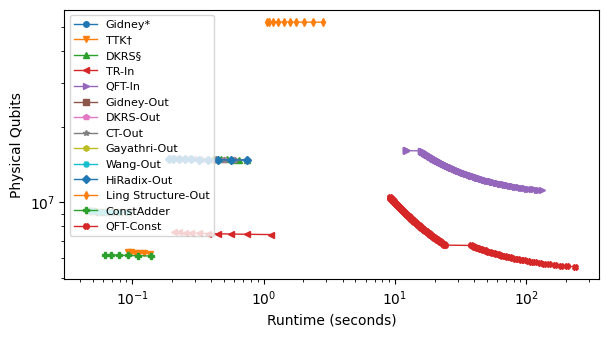

In [151]:

plt.figure(figsize=(6.9, 3.5))

#Use a distinct marker list
markers = ["o", "v", "^", "<", ">", "s", "p", "*", "h", "H", "D", "d", "P", "X"]


i =0 
for result in results:
    qubits = []
    runtimes = []
    for entry in result['frontierEntries']:
        qubits.append(entry['physicalCounts']['physicalQubits'])
        runtimes.append(entry['physicalCounts']['runtime']/10**9)
    plt.plot(runtimes, qubits, marker=markers[i%len(markers)], markersize=4, linestyle='-', linewidth=1, label=names[i])
    i += 1
plt.ylabel("Physical Qubits")
plt.xlabel("Runtime (seconds)")
plt.xscale("log")
plt.yscale("log")
# plt.title("Pareto Frontier of Quantum Adders for n=2^11 (in/out place and constant)")
plt.legend()
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=8)
fig_name = f'img/Paretofrontierdummy.png'
plt.savefig(fig_name, format='png',
                dpi=300, bbox_inches='tight')

plt.show()

In [161]:
res_dict = {}
for i in range(len(results)):
    res_dict[i] = results[i]
qsharp_widgets.EstimatesOverview(res_dict, runNames=names)

EstimatesOverview(estimates={0: {'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'err…

In [136]:
n = 2**9
names2 = []
results2 = [] 
i = 0 

# multipliers
for op, name, _ in ops_and_max_n_multiply:
    results2.append(estimate_resources_multiply_pareto(op, n))
    names2.append(name)
# dividers
for op, name, _ in ops_and_max_n_divide:
    results2.append(estimate_resources_divide_pareto(op, n))
    names2.append(name)

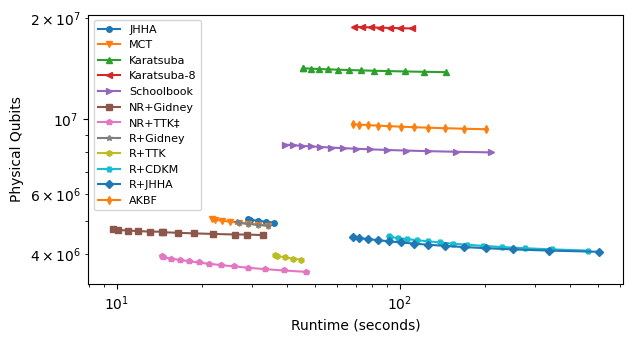

In [140]:

# plt.figure(figsize=(10, 6))
plt.figure(figsize=(6.9, 3.5))
# name for _, name, _ in ops_and_max_n]

#Use a distinct marker list
markers = ["o", "v", "^", "<", ">", "s", "p", "*", "h", "H", "D", "d", "P", "X"]

# # Use a colormap for distinct colors
# if hasattr(colors, 'LinearSegmentedColormap'):  # For newer Matplotlib versions
#     cmap = colors.LinearSegmentedColormap.from_list('', ['viridis', 'plasma', 'magma', 'inferno'][0:len(results)])
# else:  # For older Matplotlib versions
#     cmap = plt.cm.get_cmap('viridis', len(results))  # Fallback to using get_cmap if available


i =0 
for result in results2:
    qubits = []
    runtimes = []
    for entry in result['frontierEntries']:
        qubits.append(entry['physicalCounts']['physicalQubits'])
        runtimes.append(entry['physicalCounts']['runtime']/10**9)
    plt.plot(runtimes, qubits, marker=markers[i%len(markers)], markersize=4, linestyle='-', label=names2[i])
    # print(f"{names[i]},{entry['physicalCounts']['physicalQubits']},{entry['physicalCounts']['runtime']/10**9}")
    # print(f"{names2[i]},{qubits[0]},{runtimes[0]}")
    # plt.plot(runtimes, qubits, marker='x', markersize=8, label=names[i])
    i += 1
plt.ylabel("Physical Qubits")
plt.xlabel("Runtime (seconds)")
plt.xscale("log")
plt.yscale("log")
# plt.title("Pareto Frontier of Quantum Multipliers/Dividers for n=2^9")
# plt.legend(loc="upper right", bbox_to_anchor=(1, 0.95), ncol=1)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=8)
# plt.grid(linestyle='--', alpha=0.5)
fig_name = f'img/Paretofrontierdummy2.png'
plt.savefig(fig_name, format='png',
                dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# 